In [1]:
# system utility packages
import os
import pickle
import re
import subprocess

# for in-notebook display of DT surrogate image
from IPython.display import Image
from IPython.display import display

# standard analytical/modeling packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

import shap # needed to make shap summary plot

# global settings
pd.options.display.max_columns = 999 # enable display of all columns in notebook
#np.random.seed(12345) # for reproducibility of the many things that call numpy

# display standard graphics in-notebook
%matplotlib inline

In [2]:
#this needs to read from AML later
model = pickle.load(open('data/model.pkl', 'rb'))
    
# print some confirmation info
print('Pretrained model loaded from disk.')
print('Pretrained model best_iteration' + ': ' + model.attributes()['best_iteration'])
print('Pretrained model best_score' + ': ' + model.attributes()['best_score'])


Pretrained model loaded from disk.
Pretrained model best_iteration: 1721
Pretrained model best_score: 0.729427


# Model explanation scripts below

In [3]:
shap_values = np.loadtxt('data/shap_values.csv', delimiter=',') # load
print('Pre-calculated Shapley values loaded from disk.')        # print confirmation

Pre-calculated Shapley values loaded from disk.


In [4]:
#this needs to read from SQL table later
testdf_withID = pd.read_csv('data/tranformedtestset2.csv', index_col=0)
testdf = testdf_withID.drop(columns=['ID'])

In [15]:
testdf.columns.values

array(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'A1Cresult_7',
       'A1Cresult_8', 'A1Cresult_None', 'A1Cresult_Norm', 'acarbose_No',
       'acarbose_Steady', 'insulin_Down', 'insulin_No', 'insulin_Steady',
       'insulin_Up', 'diabetesMed_No', 'diabetesMed_Yes',
       'medical_specialty_q', 'medical_specialty_Cardiology',
       'medical_specialty_Emergency_Trauma',
       'medical_specialty_Family_GeneralPractice',
       'medical_specialty_InternalMedicine',
       'medical_specialty_Nephrology', 'medical_specialty_Orthopedics',
       'medical_specialty_Orthopedics_Reconstructive',
       'medical_specialty_Other', 'medical_specialty_Psychiatry',
       'medical_specialty_Surgery_General', 'glimepiride_Down',
       'glimepiride_No', 'glimepiride_Steady', 'glimepiride_Up',
       'miglitol_Down', 'miglitol_No', 'miglitol_Steady',
       'discharg

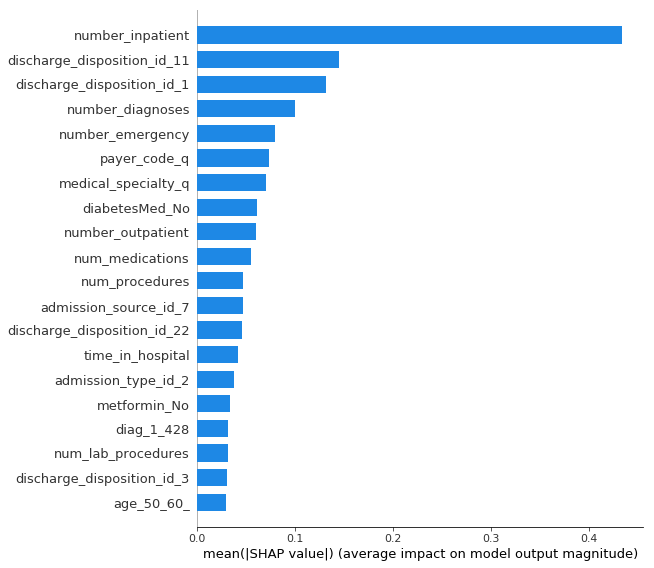

In [5]:
shap.summary_plot(shap_values[:, :-1], model.feature_names, plot_type="bar")

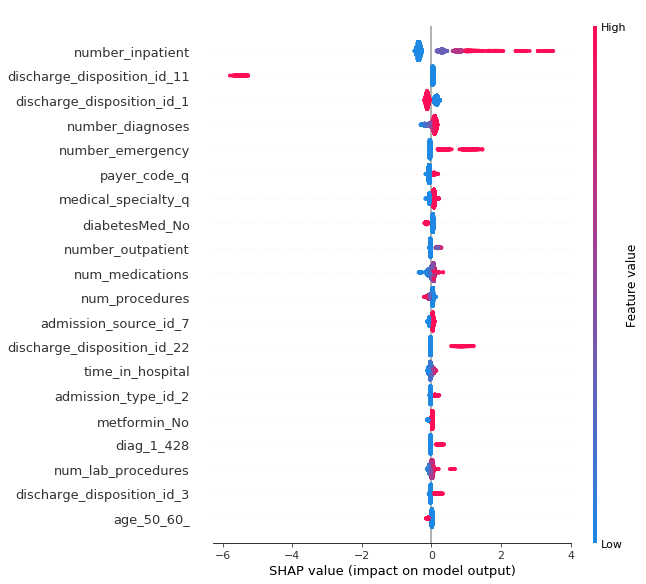

In [6]:
shap.summary_plot(shap_values[:, :-1], testdf[model.feature_names])

## Local explanation scripts below

In [7]:
def shap_localexplain(row):
    
    """ Summarize local Shapley information. 
    
    :param row: The row to explain from numpy array of Shapley values.
    
    """
    
    # select shapley values for row
    # reshape into column vector
    # convert to pandas dataframe for easy plotting
    s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(shap_values.shape[1]-1, 1), 
                        columns=['Approximate Local Contributions'],
                        index=model.feature_names) # must use feature_names for consistent results

    # sort dataframe by shapley values and print values
    s_df = s_df.sort_values(by='Approximate Local Contributions')
    #print(s_df, '\n')
    return s_df

    # plot top positive contributors for this row
    #_= s_df.iloc[-5:,:].plot(kind='bar', title='Approximate Local Contributions', legend=False)
    
    # manually calculate sum of shapley values for row
    #print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
    
    # manually calculate actual model prediction before application of logit link function
    #p = row['predict'].values[0]
    #print('Model prediction: ', np.log(p/(1 - p))) # inverse logit

In [8]:
#test['ID'] = np.arange(test.shape[0])
#test.reset_index(inplace=True)                 # create new sequential index for join directly below
#test.drop(['index'], inplace=True, axis=1)     # drop old index that came from when test set was sampled from entire data set

In [23]:
testdf_withID

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,acarbose_No,acarbose_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,diabetesMed_No,diabetesMed_Yes,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,miglitol_Down,miglitol_No,miglitol_Steady,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,gender_Female,gender_Male,gender_Unknown_Invalid,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,tolazamide_No,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,troglitazone_No,chlorpropamide_No,chlorpropamide_Steady,change_Ch,change_No,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,glyburide_metformin_No,glyburide_metformin_Steady,glipizide_metformin_No,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,tolbutamide_No,tolbutamide_Steady,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,ID
0,1,50,6,25,0,0,0,9,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,

In [22]:
row1 = testdf_withID[testdf_withID['ID'] == 3706]
type(row1)
# localexp_df = shap_localexplain(row1)
# localexp_df

pandas.core.frame.DataFrame

## Model Scoring scripts below

In [10]:
def score(testdf):
    dtest = xgb.DMatrix(testdf)
    xgb_preds = pd.DataFrame(model.predict(dtest)) # score test set to find percentiles of predictions below
    return xgb_preds

In [11]:
#testing the score function
scores = score(testdf)
scores.head()

,0
0,0.125572
1,0.052470
2,0.150182
3,0.175052
4,0.191513


In [12]:
testdf.shape

(16221, 224)